In [2]:
#librerias estandar
from pathlib import Path
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#librerias modelos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import  RandomForestRegressor,  VotingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor

#cluster
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.cluster import KMeans 

pd.set_option('display.max_columns', None)
sys.path.append('..')

#modulos propios
from utils import funciones as f

In [3]:
df = pd.read_csv(r'..\data\processed\df_limpio.csv', index_col='Unnamed: 0')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21742 entries, 0 to 21741
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   precio_venta         21742 non-null  int64  
 1   precio_venta_por_m2  21742 non-null  int64  
 2   cee                  21742 non-null  object 
 3   balcon               21742 non-null  bool   
 4   armarios_empotrados  21742 non-null  bool   
 5   jardin               21742 non-null  bool   
 6   zonas_verdes         21742 non-null  bool   
 7   estacionamiento      21742 non-null  bool   
 8   pileta               21742 non-null  bool   
 9   trastero             21742 non-null  bool   
 10  terraza              21742 non-null  bool   
 11  tipo_inmueble        21742 non-null  object 
 12  accesible            21742 non-null  bool   
 13  exterior             21742 non-null  bool   
 14  bajo                 21742 non-null  bool   
 15  necesita_reforma     21742 non-null  bool

In [5]:
f.cardinalidad(df)

,variable,tipo_dato,cantidad_de_nulos,valores_unicos,cardinalidad,porcentaje_cardinalidad
0,precio_venta,int64,0,"[85000, 72000, 76000, 110000, 94000, 120000, 1...",2403,11.052341
1,precio_venta_por_m2,int64,0,"[1328, 1125, 1188, 1719, 1446, 1692, 1846, 166...",5643,25.954374
2,cee,object,0,"[D, F, en trámite, E, G, no indicado, B, A, in...",10,0.045994
3,balcon,bool,0,"[False, True]",2,0.009199
4,armarios_empotrados,bool,0,"[False, True]",2,0.009199
5,jardin,bool,0,"[False, True]",2,0.009199
6,zonas_verdes,bool,0,"[False, True]",2,0.009199
7,estacionamiento,bool,0,"[False, True]",2,0.009199
8,pileta,bool,0,"[False, True]",2,0.009199
9,trastero,bool,0,"[False, True]",2,0.009199


## Tratamiento de columnas

LABEL ENCODER:
- **zona**

ORDINAL ENCODER:
- **cee**

ONE HOT ENCODER:
- **tipo_inmueble**

MAPEO:
- **balcon/armarios_empotrados/jardin/zonas_verdes/estacionamiento/pileta/trastero/terraza/accesible/exterior/bajo/necesita_reforma**

ESCALADO:
- **annio_construccion** 
- **metros_cuadrados**

ELIMINAR/NO TRANSFORMAR:
- **precio_venta** (tiene mucha colinealidad con nuestra variable target por lo que muy posiblemente la tengamos que eliminar)
- **ubicacion** (eliminar porque tenemos zonas, que es más global)
- **piso**
- **habitaciones** 
- **bannos**

TARGET:
- **precio_venta_por_m2** TARGET - escalado y log


In [6]:
df['precio_venta_por_m2'].describe()

count    21742.000000
mean      4020.523871
std       1908.418774
min        447.000000
25%       2551.000000
50%       3720.000000
75%       5000.000000
max      18889.000000
Name: precio_venta_por_m2, dtype: float64

## División de los datos

In [7]:
X = df.drop(columns=['precio_venta_por_m2'], axis=1)
y = df['precio_venta_por_m2']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 33)

In [9]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
X_test.to_csv(r'..\data\processed\X_test.csv')
y_test.to_csv(r'..\data\processed\y_test.csv')

## Pre procesamiento X_TRAIN

#### CEE

In [11]:
o_encoder = OrdinalEncoder(categories=[["no indicado", "inmueble exento", 
                                      "en trámite", "G", "F", "E", 
                                      "D", "C", "B", "A" 
                                      ]])

o_encoder.fit(X_train[["cee"]])
X_train["cee_e"] = o_encoder.transform(X_train[["cee"]])
X_train.drop(columns=['cee'], inplace=True)

#### ZONA

In [12]:
l_encoder = LabelEncoder()
X_train['zona_e'] = l_encoder.fit_transform(X_train['zona'])
X_train.drop(columns=['zona', 'ubicacion'], inplace=True)

#### TIPO INMUEBLE

In [13]:
oh_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded = oh_encoder.fit_transform(X_train[['tipo_inmueble']])
encoded_df = pd.DataFrame(encoded, columns=oh_encoder.get_feature_names_out(['tipo_inmueble']))

X_train = pd.concat([X_train, encoded_df], axis=1)
X_train = X_train.drop(['tipo_inmueble'], axis=1)

#### VARIABLES BINARIAS

In [14]:
X_train = f.tranformacion_numerica(X_train)

#### ESCALADO

In [15]:
columnas_esc = ['annio_construccion', 'metros_cuadrados']
scaler = RobustScaler()
X_train[columnas_esc] = scaler.fit_transform(X_train[columnas_esc])

#### ELIMINAR

In [16]:
X_train.drop(columns=['piso', 'precio_venta', 'jardin', 'zonas_verdes', 'accesible', 'bajo', 'pileta', 'exterior', 'necesita_reforma', 'habitaciones'], inplace=True)

## Pre procesamiento Y_TRAIN

In [17]:
y_train

0        1933
1        6824
2        3386
3        7303
4        4129
         ... 
17388    2292
17389    1023
17390    1429
17391    2288
17392    4746
Name: precio_venta_por_m2, Length: 17393, dtype: int64

In [18]:
y_train = np.sqrt(y_train)

# y_train = np.log(y_train)
# # scaler_0 = RobustScaler()
# # y_train = scaler_0.fit_transform(y_train)

<Axes: >

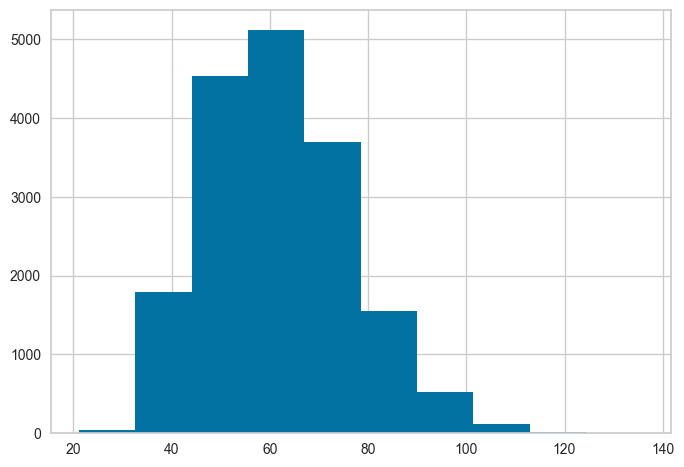

In [19]:
y_train.hist()

## Correlaciones entre las variables

In [20]:
df_completo = pd.concat([X_train, y_train], axis=1)

In [21]:
df_completo

,balcon,armarios_empotrados,estacionamiento,trastero,terraza,annio_construccion,metros_cuadrados,bannos,latitud,longitud,cee_e,zona_e,tipo_inmueble_HouseType 1: Pisos,tipo_inmueble_HouseType 2: Casa o chalet,tipo_inmueble_HouseType 4: Dúplex,tipo_inmueble_HouseType 5: Áticos,precio_venta_por_m2
0,0,0,0,0,1,0.000000,-0.260417,1.0,40.374211,-3.744676,2.0,2,1.0,0.0,0.0,0.0,43.965896
1,0,1,1,1,1,-0.241379,2.927083,4.0,40.438962,-3.705302,2.0,5,1.0,0.0,0.0,0.0,82.607506
2,0,1,0,0,0,0.931034,-0.583333,1.0,40.384376,-3.699293,2.0,16,1.0,0.0,0.0,0.0,58.189346
3,0,0,0,0,0,-1.379310,-0.114583,1.0,40.424699,-3.676200,0.0,14,1.0,0.0,0.0,0.0,85.457592
4,0,0,0,0,1,0.137931,-0.312500,1.0,40.458987,-3.676129,2.0,4,1.0,0.0,0.0,0.0,64.257295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17388,0,1,1,0,0,1.206897,0.312500,2.0,40.397050,-3.729354,6.0,2,1.0,0.0,0.0,0.0,47.874837
17389,0,0,0,0,0,-0.344828,-0.187500,1.0,40.343354,-3.687817,2.0,19,1.0,0.0,0.0,0.0,31.984371
17390,0,0,0,0,1,-0.172414,-0.458333,1.0,40.345610,-3.695956,2.0,19,1.0,0.0,0.0,0.0,37.802116
17391,1,1,1,1,1,0.620690,2.822917,4.0,40.478964,-3.725842,5.0,7,0.0,1.0,0.0,0.0,47.833043


<Axes: >

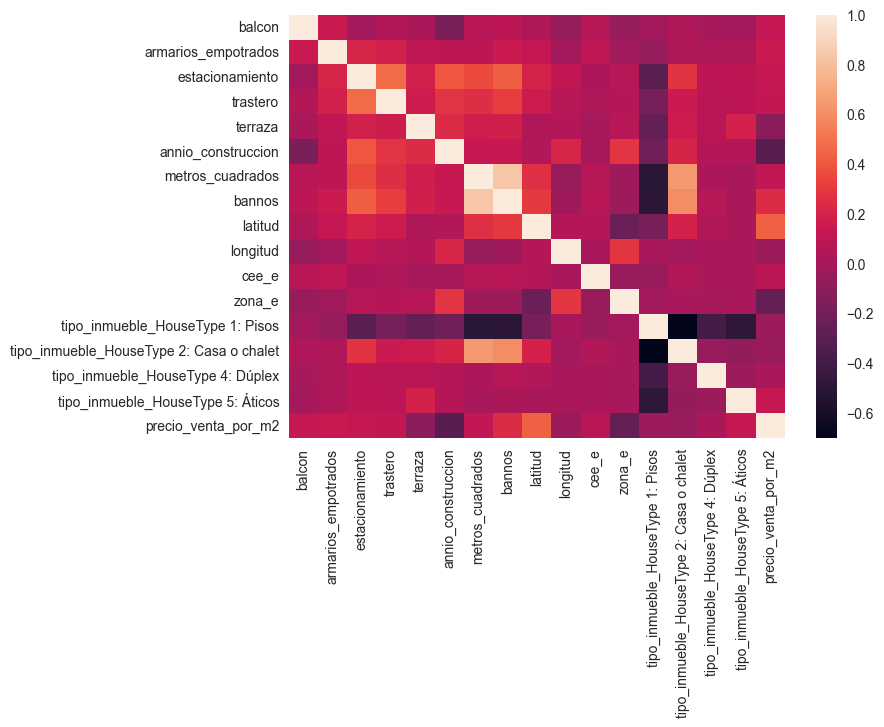

In [22]:

sns.heatmap(df_completo.corr())

In [23]:
df_completo.corr()

,balcon,armarios_empotrados,estacionamiento,trastero,terraza,annio_construccion,metros_cuadrados,bannos,latitud,longitud,cee_e,zona_e,tipo_inmueble_HouseType 1: Pisos,tipo_inmueble_HouseType 2: Casa o chalet,tipo_inmueble_HouseType 4: Dúplex,tipo_inmueble_HouseType 5: Áticos,precio_venta_por_m2
balcon,1.000000,0.138474,-0.010097,0.047525,0.009411,-0.164915,0.072629,0.085576,0.032351,-0.059847,0.063029,-0.064181,-0.017172,0.034530,-0.003645,-0.013627,0.118464
armarios_empotrados,0.138474,1.000000,0.213782,0.187024,0.101759,0.091494,0.089111,0.146758,0.119465,-0.008913,0.099528,-0.021100,-0.061814,0.031358,0.036317,0.037178,0.141027
estacionamiento,-0.010097,0.213782,1.000000,0.468929,0.187180,0.401289,0.352167,0.423961,0.199736,0.103270,0.023469,0.064653,-0.297579,0.269787,0.084999,0.090566,0.124443
trastero,0.047525,0.187024,0.468929,1.000000,0.156301,0.278218,0.253438,0.308889,0.154097,0.065222,0.032831,0.050105,-0.189993,0.144560,0.069462,0.083131,0.110793
terraza,0.009411,0.101759,0.187180,0.156301,1.000000,0.238941,0.169622,0.175370,0.041135,0.050839,0.001358,0.062822,-0.260719,0.153143,0.073225,0.193873,-0.108756
annio_construccion,-0.164915,0.091494,0.401289,0.278218,0.238941,1.000000,0.130108,0.132872,0.046858,0.214338,-0.004359,0.275929,-0.215911,0.206523,0.061559,0.051104,-0.309726
metros_cuadrados,0.072629,0.089111,0.352167,0.253438,0.169622,0.130108,1.000000,0.837423,0.256287,-0.055489,0.063387,-0.030936,-0.512071,0.644484,0.027052,0.007750,0.106281
bannos,0.085576,0.146758,0.423961,0.308889,0.175370,0.132872,0.837423,1.000000,0.296935,-0.029237,0.070683,-0.040468,-0.496837,0.597313,0.062097,0.016317,0.238630
latitud,0.032351,0.119465,0.199736,0.154097,0.041135,0.046858,0.256287,0.296935,1.000000,0.060143,0.052425,-0.236559,-0.179404,0.194904,0.044339,0.016269,0.430504
longitud,-0.059847,-0.008913,0.103270,0.065222,0.050839,0.214338,-0.055489,-0.029237,0.060143,1.000000,0.002607,0.284005,0.002628,-0.014011,0.006353,0.009237,-0.043469


array([[<Axes: title={'center': 'balcon'}>,
        <Axes: title={'center': 'armarios_empotrados'}>,
        <Axes: title={'center': 'estacionamiento'}>,
        <Axes: title={'center': 'trastero'}>],
       [<Axes: title={'center': 'terraza'}>,
        <Axes: title={'center': 'annio_construccion'}>,
        <Axes: title={'center': 'metros_cuadrados'}>,
        <Axes: title={'center': 'bannos'}>],
       [<Axes: title={'center': 'latitud'}>,
        <Axes: title={'center': 'longitud'}>,
        <Axes: title={'center': 'cee_e'}>,
        <Axes: title={'center': 'zona_e'}>],
       [<Axes: title={'center': 'tipo_inmueble_HouseType 1: Pisos'}>,
        <Axes: title={'center': 'tipo_inmueble_HouseType 2: Casa o chalet'}>,
        <Axes: title={'center': 'tipo_inmueble_HouseType 4: Dúplex'}>,
        <Axes: title={'center': 'tipo_inmueble_HouseType 5: Áticos'}>]],
      dtype=object)

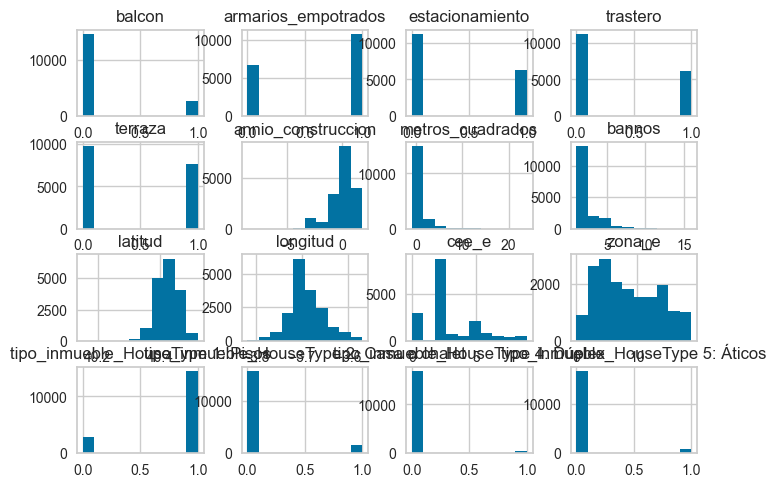

In [24]:
X_train.hist()

## Modelo

In [23]:
model_0 = SVR()
model_1 = LinearRegression()
model_2 = Ridge()
model_3 = Lasso()
model_4 = ElasticNet()
model_5 = RandomForestRegressor()
model_6 = GradientBoostingRegressor()
model_7 = HistGradientBoostingRegressor()
model_8 = XGBRegressor()

models = [model_0, model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]

In [24]:
dicc = {}

for model in models:
    scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores


,0
SVR - RMSE,1911.964917
ElasticNet - RMSE,1695.901338
Lasso - RMSE,1520.547308
Ridge - RMSE,1520.387267
LinearRegression - RMSE,1520.060757
GradientBoostingRegressor - RMSE,1122.764213
HistGradientBoostingRegressor - RMSE,1022.012192
XGBRegressor - RMSE,1005.901817
RandomForestRegressor - RMSE,1003.212400


#### Tenemos los 3 mejores modelos
Voy a aplicar un Grid Search para poder mejorarlos

In [25]:
model_11 = RandomForestRegressor()
model_22 = HistGradientBoostingRegressor()
model_33 = XGBRegressor()

In [26]:
models_1 = model_11, model_22, model_33

In [27]:
print(type(model_11).__name__)

RandomForestRegressor


In [28]:
lista_params = []
for i in models_1:
    if type(i).__name__ == 'RandomForestRegressor':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [2, 3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    elif type(i).__name__ == 'HistGradientBoostingRegressor':
        param_grid = {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_leaf_nodes': [5, 10, 50],
            'min_samples_leaf': [5, 10, 30],
            'max_depth': [2, 5, 10]
        }
    else:
        param_grid = {
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'min_child_weight': [1, 3, 5]
        }

    grid_search = GridSearchCV(i,
                            param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1
                            )

    grid_search.fit(X_train, y_train)
    lista_params.append(grid_search.best_params_)

In [29]:
lista_params

[{'bootstrap': False,
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 {'learning_rate': 0.1,
  'max_depth': 10,
  'max_iter': 300,
  'max_leaf_nodes': 50,
  'min_samples_leaf': 5},
 {'learning_rate': 0.1,
  'max_depth': 9,
  'min_child_weight': 3,
  'n_estimators': 200}]

El random Forest es mejor con los hiperparametros por defecto que con el grid search

In [25]:
base_models=[
                    ('rfr', RandomForestRegressor()),
                    ('hs', HistGradientBoostingRegressor(learning_rate = 0.1,
                                        max_depth = 10,
                                        max_iter = 300,
                                        max_leaf_nodes = 50,
                                        min_samples_leaf = 5)),
                    ('xgb', XGBRegressor(learning_rate = 0.1,
                                max_depth = 9,
                                min_child_weight = 3,
                                n_estimators = 300))
                ]

meta_model = LinearRegression()

In [26]:
model_completo_111 = RandomForestRegressor()
model_completo_222 = HistGradientBoostingRegressor(learning_rate = 0.1,
                            max_depth = 10,
                            max_iter = 300,
                            max_leaf_nodes = 50,
                            min_samples_leaf = 5)
model_completo_333 = XGBRegressor(learning_rate = 0.1,
                    max_depth = 9,
                    min_child_weight = 3,
                    n_estimators = 300)
model_completo_444 = VotingRegressor(
                estimators=base_models
            )
model_completo_555 = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [32]:
models_2 = [model_completo_111, model_completo_222, model_completo_333, model_completo_444, model_completo_555]

In [33]:
dicc = {}

for model in models_2:
    scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
RandomForestRegressor - RMSE,1002.610234
HistGradientBoostingRegressor - RMSE,1002.110584
XGBRegressor - RMSE,993.994325
StackingRegressor - RMSE,972.724030
VotingRegressor - RMSE,971.506072


In [34]:
model_completo_111.fit(X_train, y_train)
model_completo_222.fit(X_train, y_train)
model_completo_333.fit(X_train, y_train)
model_completo_444.fit(X_train, y_train)

VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('hs',
                             HistGradientBoostingRegressor(max_depth=10,
                                                           max_iter=300,
                                                           max_leaf_nodes=50,
                                                           min_samples_leaf=5)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=9,
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [27]:
model_completo_555.fit(X_train, y_train)

KeyboardInterrupt: 

## TRanformamos el X_test

In [18]:
# X_test = pd.read_csv(r'..\data\processed\X_test.csv', index_col='Unnamed: 0')
# y_test = pd.read_csv(r'..\data\processed\y_test.csv', index_col='Unnamed: 0')

In [19]:
# o_encoder = OrdinalEncoder(categories=[["no indicado", "inmueble exento", 
#                                       "en trámite", "G", "F", "E", 
#                                       "D", "C", "B", "A" 
#                                       ]])

# o_encoder.fit(X_test[["cee"]])
X_test["cee_e"] = o_encoder.transform(X_test[["cee"]])
X_test.drop(columns=['cee'], inplace=True)

In [20]:
X_test['zona_e'] = l_encoder.transform(X_test['zona'])
X_test.drop(columns=['zona', 'ubicacion'], inplace=True)

In [21]:
encoded = oh_encoder.transform(X_test[['tipo_inmueble']])
encoded_df = pd.DataFrame(encoded, columns=oh_encoder.get_feature_names_out(['tipo_inmueble']))

X_test = pd.concat([X_test, encoded_df], axis=1)
X_test = X_test.drop(['tipo_inmueble'], axis=1)

In [22]:
X_test = f.tranformacion_numerica(X_test)

In [23]:
columnas_esc = ['annio_construccion', 'metros_cuadrados']
X_test[columnas_esc] = scaler.transform(X_test[columnas_esc])

In [24]:
X_test.drop(columns=['piso', 'precio_venta', 'jardin', 'zonas_verdes', 'accesible', 'bajo', 'pileta', 'exterior', 'necesita_reforma', 'habitaciones'], inplace=True)

In [43]:
predicc = model_completo_555.predict(X_test)

In [44]:
print('RMSE :',np.sqrt(mean_squared_error(y_test,predicc)))

RMSE : 957.3758323285698


## Ahora probamos si con un cluster podemos mejorar el porcentaje

porque no tenemos mucha diferencia entre los precios de los áticos que son los más costosos y los pisos pequeños por ejemplo

In [24]:
for i in range(2,21):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_train)
    predd = km.predict(X_train)
    print(f'K = {i}')
    print(silhouette_score(X_train, km.labels_))
    print(km.inertia_)

K = 2
0.4488046218078518
335121.3127409015
K = 3
0.3317567737580541
260268.14712767876
K = 4
0.3253539201177902
221805.47016753023
K = 5
0.262068620374553
204060.14970148512
K = 6
0.26272243528349276
193442.7240527816
K = 7
0.2449700228956339
177339.85025437895
K = 8
0.2717899400741604
146150.91527313163
K = 9
0.24895491159998445
134673.00737535322
K = 10
0.24461601410305853
129714.00553390068
K = 11
0.24714797795537896
121986.57056210109
K = 12
0.24839184160952152
115092.84336900081
K = 13
0.25352388280673377
109430.20267191189
K = 14
0.250315077764781
104342.40190510062
K = 15
0.2392106084474638
100155.65910073351
K = 16
0.23497995330260177
98027.97615931138
K = 17
0.2341173561651869
95506.47494466796
K = 18
0.23371877012642542
93745.88973017762
K = 19
0.22316670404531969
91119.81587946496
K = 20
0.22449958408294016
88050.70027912135


In [25]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train)
                for k in range(2, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [26]:
kmeans_per_k

[KMeans(n_clusters=2, random_state=42),
 KMeans(n_clusters=3, random_state=42),
 KMeans(n_clusters=4, random_state=42),
 KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=6, random_state=42),
 KMeans(n_clusters=7, random_state=42),
 KMeans(random_state=42),
 KMeans(n_clusters=9, random_state=42),
 KMeans(n_clusters=10, random_state=42),
 KMeans(n_clusters=11, random_state=42),
 KMeans(n_clusters=12, random_state=42),
 KMeans(n_clusters=13, random_state=42),
 KMeans(n_clusters=14, random_state=42),
 KMeans(n_clusters=15, random_state=42),
 KMeans(n_clusters=16, random_state=42),
 KMeans(n_clusters=17, random_state=42),
 KMeans(n_clusters=18, random_state=42),
 KMeans(n_clusters=19, random_state=42)]

In [27]:
inertias

[335121.3127409015,
 260268.14712767876,
 221805.47016753023,
 204060.14970148512,
 193442.72405278156,
 177339.85025437892,
 146150.91527313163,
 134673.00737535325,
 129714.00553390068,
 121986.57056210109,
 115092.84336900081,
 109430.20267191189,
 104342.40190510063,
 100155.65910073351,
 98027.9761593114,
 95506.47494466796,
 93745.88973017762,
 91119.81587946496]

In [28]:
df_kmeans = pd.DataFrame(inertias, columns=['inertia'])
df_kmeans['inertia_1'] = df_kmeans['inertia'].shift(1)
df_kmeans['diff%'] = df_kmeans['inertia']/df_kmeans['inertia_1']
df_kmeans

,inertia,inertia_1,diff%
0,335121.312741,NaN,NaN
1,260268.147128,335121.312741,0.776639
2,221805.470168,260268.147128,0.852219
3,204060.149701,221805.470168,0.919996
4,193442.724053,204060.149701,0.947969
5,177339.850254,193442.724053,0.916756
6,146150.915273,177339.850254,0.824129
7,134673.007375,146150.915273,0.921465
8,129714.005534,134673.007375,0.963177
9,121986.570562,129714.005534,0.940427


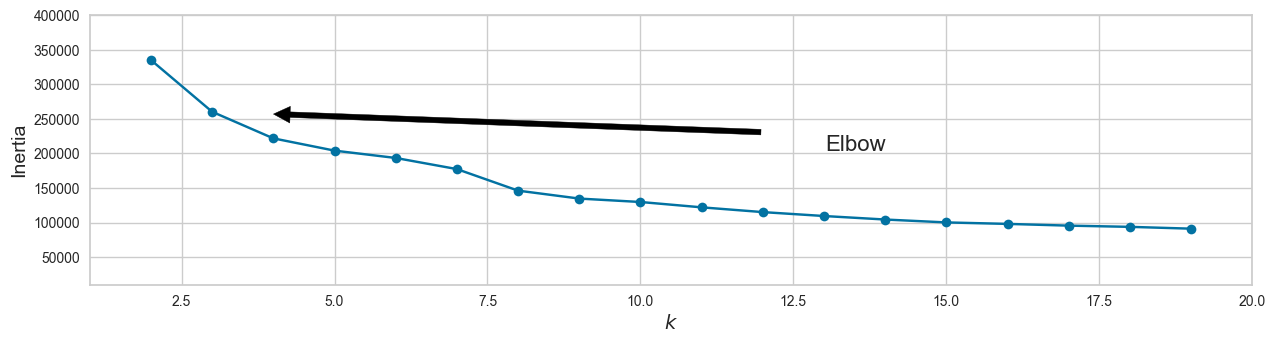

In [29]:
plt.figure(figsize=(15, 3.5))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 20, 10000, 400000])
plt.show()

In [25]:
km_0 = KMeans(n_clusters=3, random_state=42)
km_0.fit(X_train)
predd = km_0.predict(X_train)
print(f'K = 3')
print(silhouette_score(X_train, km_0.labels_))
print(km_0.inertia_)

c:\Users\ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K = 3
0.3317570144936343
260267.94550080094


c:\Users\ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


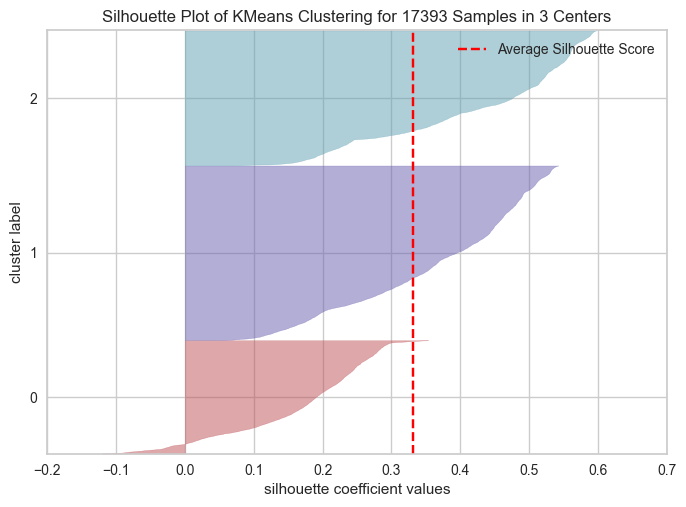

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 17393 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors=['#BE5056', '#695FAF', '#61A1B3'],
                     estimator=KMeans(n_clusters=3, random_state=42))

In [111]:
color_pred_0 = '#BE5056' #rojo
color_pred_1 = '#695FAF' #violeta
color_pred_2 = '#61A1B3' #azul

silhouette_visualizer(km_0, X_train, colors=[color_pred_0, color_pred_1, color_pred_2])

In [28]:
df_c = pd.DataFrame(predd, columns=['Cluster'])

<AxesSubplot: ylabel='count'>

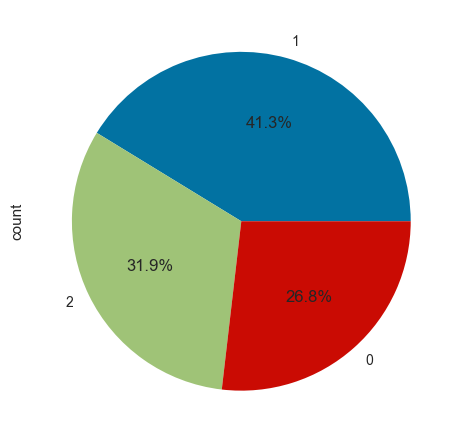

In [33]:
df_c['Cluster'].value_counts().plot.pie(autopct="%.1f%%")

In [29]:

X_train_clust = pd.concat([X_train, df_c], axis=1)

In [30]:
X_train_clust

,balcon,armarios_empotrados,estacionamiento,trastero,terraza,annio_construccion,metros_cuadrados,bannos,latitud,longitud,cee_e,zona_e,tipo_inmueble_HouseType 1: Pisos,tipo_inmueble_HouseType 2: Casa o chalet,tipo_inmueble_HouseType 4: Dúplex,tipo_inmueble_HouseType 5: Áticos,Cluster
0,0,0,0,0,1,0.000000,-0.260417,1.0,40.374211,-3.744676,2.0,2,1.0,0.0,0.0,0.0,1
1,0,1,1,1,1,-0.241379,2.927083,4.0,40.438962,-3.705302,2.0,5,1.0,0.0,0.0,0.0,1
2,0,1,0,0,0,0.931034,-0.583333,1.0,40.384376,-3.699293,2.0,16,1.0,0.0,0.0,0.0,2
3,0,0,0,0,0,-1.379310,-0.114583,1.0,40.424699,-3.676200,0.0,14,1.0,0.0,0.0,0.0,2
4,0,0,0,0,1,0.137931,-0.312500,1.0,40.458987,-3.676129,2.0,4,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17388,0,1,1,0,0,1.206897,0.312500,2.0,40.397050,-3.729354,6.0,2,1.0,0.0,0.0,0.0,1
17389,0,0,0,0,0,-0.344828,-0.187500,1.0,40.343354,-3.687817,2.0,19,1.0,0.0,0.0,0.0,2
17390,0,0,0,0,1,-0.172414,-0.458333,1.0,40.345610,-3.695956,2.0,19,1.0,0.0,0.0,0.0,2
17391,1,1,1,1,1,0.620690,2.822917,4.0,40.478964,-3.725842,5.0,7,0.0,1.0,0.0,0.0,0


Probamos hacer predicciones con este cluster

In [31]:
df_unido = pd.concat([X_train_clust, y_train], axis=1)

In [32]:
df_unido_0 = df_unido[df_unido['Cluster'] == 0]

In [33]:

df_unido_1 = df_unido[df_unido['Cluster'] == 1]

In [34]:

df_unido_2 = df_unido[df_unido['Cluster'] == 2]

Como ya entrené los modelos anteriormente voy a probar si tengo los mismos resultados con esos modelos

In [42]:
model_0 = SVR()
model_1 = LinearRegression()
model_2 = Ridge()
model_3 = Lasso()
model_4 = ElasticNet()
model_5 = RandomForestRegressor()
model_6 = GradientBoostingRegressor()
model_7 = HistGradientBoostingRegressor()
model_8 = XGBRegressor()

models = [model_0, model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]

## Cluster 0

Dividimos en X_train e Y_train

In [40]:
X_train_0 = df_unido_0.drop(columns='precio_venta_por_m2')
y_train_0 = df_unido_0['precio_venta_por_m2']

In [63]:
dicc = {}

for model in models:
    scores = -cross_val_score(model, X_train_0, y_train_0, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
SVR - RMSE,1425.666664
ElasticNet - RMSE,1338.030362
Ridge - RMSE,1274.646911
Lasso - RMSE,1273.832489
LinearRegression - RMSE,1273.191895
GradientBoostingRegressor - RMSE,972.917286
XGBRegressor - RMSE,917.273273
HistGradientBoostingRegressor - RMSE,908.068774
RandomForestRegressor - RMSE,903.041332


In [64]:
lista_params = []
for i in models_1:
    if type(i).__name__ == 'RandomForestRegressor':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [2, 3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    elif type(i).__name__ == 'HistGradientBoostingRegressor':
        param_grid = {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_leaf_nodes': [5, 10, 50],
            'min_samples_leaf': [5, 10, 30],
            'max_depth': [2, 5, 10]
        }
    else:
        param_grid = {
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'min_child_weight': [1, 3, 5]
        }

    grid_search = GridSearchCV(i,
                            param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1
                            )

    grid_search.fit(X_train_0, y_train_0)
    lista_params.append(grid_search.best_params_)
lista_params

[{'bootstrap': False,
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 {'learning_rate': 0.1,
  'max_depth': 5,
  'max_iter': 200,
  'max_leaf_nodes': 50,
  'min_samples_leaf': 5},
 {'learning_rate': 0.1,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 100}]

In [65]:
lista_params

[{'bootstrap': False,
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 {'learning_rate': 0.1,
  'max_depth': 5,
  'max_iter': 200,
  'max_leaf_nodes': 50,
  'min_samples_leaf': 5},
 {'learning_rate': 0.1,
  'max_depth': 9,
  'min_child_weight': 5,
  'n_estimators': 100}]

In [43]:
model_cl0_111 = RandomForestRegressor()
model_cl0_222 = HistGradientBoostingRegressor(learning_rate = 0.1,
                            max_depth = 5,
                            max_iter = 200,
                            max_leaf_nodes = 50,
                            min_samples_leaf = 5)
model_cl0_333 = XGBRegressor(learning_rate = 0.1,
                    max_depth = 9,
                    min_child_weight = 5,
                    n_estimators = 100)

base_models=[
                    ('rfr', RandomForestRegressor()),
                    ('hs', HistGradientBoostingRegressor(learning_rate = 0.1,
                                        max_depth = 5,
                                        max_iter = 200,
                                        max_leaf_nodes = 50,
                                        min_samples_leaf = 5)),
                    ('xgb', XGBRegressor(learning_rate = 0.1,
                                max_depth = 9,
                                min_child_weight = 5,
                                n_estimators = 100))
                ]
model_cl0_444 = VotingRegressor(
                estimators=base_models
            )

meta_model = LinearRegression()

model_555 = StackingRegressor(estimators=base_models, final_estimator=meta_model)

models_2 = [model_cl0_111, model_cl0_222, model_cl0_333, model_cl0_444, model_555]

In [67]:
dicc = {}

for model in models_2:
    scores = -cross_val_score(model, X_train_0, y_train_0, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
RandomForestRegressor - RMSE,910.282661
HistGradientBoostingRegressor - RMSE,908.898849
XGBRegressor - RMSE,904.625497
VotingRegressor - RMSE,888.725755
StackingRegressor - RMSE,884.490379


In [68]:
model_cl0_111.fit(X_train_0, y_train_0)
model_cl0_222.fit(X_train_0, y_train_0)
model_cl0_333.fit(X_train_0, y_train_0)
model_cl0_444.fit(X_train_0, y_train_0)

VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('hs',
                             HistGradientBoostingRegressor(max_depth=10,
                                                           max_iter=300,
                                                           max_leaf_nodes=50,
                                                           min_samples_leaf=5)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=9,
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [44]:
model_c_0 = model_555

In [45]:
model_c_0.fit(X_train_0, y_train_0)

StackingRegressor(estimators=[('rfr', RandomForestRegressor()),
                              ('hs',
                               HistGradientBoostingRegressor(max_depth=5,
                                                             max_iter=200,
                                                             max_leaf_nodes=50,
                                                             min_samples_leaf=5)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None, min_child_weight=5,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

## Cluster 1

In [53]:
X_train_1 = df_unido_1.drop(columns='precio_venta_por_m2')
y_train_1 = df_unido_1['precio_venta_por_m2']

In [72]:
dicc = {}

for model in models:
    scores = -cross_val_score(model, X_train_1, y_train_1, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
SVR - RMSE,1896.013004
ElasticNet - RMSE,1647.452295
Ridge - RMSE,1479.278372
Lasso - RMSE,1451.946926
LinearRegression - RMSE,1448.689543
GradientBoostingRegressor - RMSE,1130.857020
XGBRegressor - RMSE,1077.563792
HistGradientBoostingRegressor - RMSE,1072.686859
RandomForestRegressor - RMSE,1061.495339


In [73]:
models_1 = model_8, model_7, model_5

In [74]:
lista_params = []
for i in models_1:
    if type(i).__name__ == 'RandomForestRegressor':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [2, 3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    elif type(i).__name__ == 'HistGradientBoostingRegressor':
        param_grid = {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_leaf_nodes': [5, 10, 50],
            'min_samples_leaf': [5, 10, 30],
            'max_depth': [2, 5, 10]
        }
    else:
        param_grid = {
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'min_child_weight': [1, 3, 5]
        }

    grid_search = GridSearchCV(i,
                            param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1
                            )

    grid_search.fit(X_train_1, y_train_1)
    lista_params.append(grid_search.best_params_)
lista_params

[{'learning_rate': 0.1,
  'max_depth': 6,
  'min_child_weight': 5,
  'n_estimators': 200},
 {'learning_rate': 0.1,
  'max_depth': 10,
  'max_iter': 200,
  'max_leaf_nodes': 50,
  'min_samples_leaf': 5},
 {'bootstrap': False,
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200}]

In [54]:
model_cl1_111 = RandomForestRegressor()
model_cl1_222 = HistGradientBoostingRegressor(learning_rate = 0.1,
                            max_depth = 10,
                            max_iter = 200,
                            max_leaf_nodes = 50,
                            min_samples_leaf = 5)
model_cl1_333 = XGBRegressor(learning_rate = 0.1,
                    max_depth = 6,
                    min_child_weight = 5,
                    n_estimators = 100)
base_models=[
                    ('rfr', model_cl1_111),
                    ('hs', model_cl1_222),
                    ('xgb', model_cl1_333)
                ]

model_cl1_444 = VotingRegressor(
                estimators=base_models
            )

meta_model = LinearRegression()

model_555 = StackingRegressor(estimators=base_models, final_estimator=meta_model)

models_2 = [model_cl1_111, model_cl1_222, model_cl1_333, model_555, model_cl1_444]

In [76]:
dicc = {}

for model in models_2:
    scores = -cross_val_score(model, X_train_1, y_train_1, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
XGBRegressor - RMSE,1074.152280
RandomForestRegressor - RMSE,1060.629546
HistGradientBoostingRegressor - RMSE,1057.074012
VotingRegressor - RMSE,1041.211590
StackingRegressor - RMSE,1038.902216


In [77]:
model_cl1_111.fit(X_train_1, y_train_1)
model_cl1_222.fit(X_train_1, y_train_1)
model_cl1_333.fit(X_train_1, y_train_1)
model_cl1_444.fit(X_train_1, y_train_1)

VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('hs',
                             HistGradientBoostingRegressor(max_depth=10,
                                                           max_iter=200,
                                                           max_leaf_nodes=50,
                                                           min_samples_leaf=5)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=6,
                                          max_leaves=None, min_child_weight=5,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [55]:
model_c_1 = model_555

In [56]:
model_c_1.fit(X_train_1, y_train_1)

StackingRegressor(estimators=[('rfr', RandomForestRegressor()),
                              ('hs',
                               HistGradientBoostingRegressor(max_depth=10,
                                                             max_iter=200,
                                                             max_leaf_nodes=50,
                                                             min_samples_leaf=5)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorica...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=5,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

## Cluster 2

In [89]:
X_train_2 = df_unido_2.drop(columns='precio_venta_por_m2')
y_train_2 = df_unido_2['precio_venta_por_m2']

In [81]:
dicc = {}

for model in models:
    scores = -cross_val_score(model, X_train_2, y_train_2, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
SVR - RMSE,2217.225868
ElasticNet - RMSE,1674.642952
Ridge - RMSE,1478.789012
Lasso - RMSE,1475.808932
LinearRegression - RMSE,1474.955865
GradientBoostingRegressor - RMSE,1025.706515
XGBRegressor - RMSE,986.575071
RandomForestRegressor - RMSE,975.224664
HistGradientBoostingRegressor - RMSE,954.437421


In [82]:
models_1 = model_5, model_7, model_8

In [83]:
lista_params = []
for i in models_1:
    if type(i).__name__ == 'RandomForestRegressor':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [2, 3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    elif type(i).__name__ == 'HistGradientBoostingRegressor':
        param_grid = {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_leaf_nodes': [5, 10, 50],
            'min_samples_leaf': [5, 10, 30],
            'max_depth': [2, 5, 10]
        }
    else:
        param_grid = {
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'min_child_weight': [1, 3, 5]
        }

    grid_search = GridSearchCV(i,
                            param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1
                            )

    grid_search.fit(X_train_2, y_train_2)
    lista_params.append(grid_search.best_params_)
lista_params

[{'bootstrap': False,
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 {'learning_rate': 0.1,
  'max_depth': 5,
  'max_iter': 200,
  'max_leaf_nodes': 50,
  'min_samples_leaf': 5},
 {'learning_rate': 0.1,
  'max_depth': 6,
  'min_child_weight': 5,
  'n_estimators': 100}]

El Hist queda sin hiperparametros porque cuando lo probe me subia el error dando esos hiperparametros

In [90]:
model_cl2_111 = RandomForestRegressor()
model_cl2_222 = HistGradientBoostingRegressor()
model_cl2_333 = XGBRegressor(learning_rate = 0.1,
                    max_depth = 7,
                    min_child_weight = 5,
                    n_estimators = 100)
base_models=[
                    ('rfr', model_cl2_111),
                    ('hs', model_cl2_222),
                    ('xgb', model_cl2_333)
                ]

model_444 = VotingRegressor(
                estimators=base_models
            )

meta_model = LinearRegression()

model_cl2_555 = StackingRegressor(estimators=base_models, final_estimator=meta_model)

models_2 = [model_cl2_111, model_cl2_222, model_cl2_333, model_444, model_cl2_555]

In [85]:
dicc = {}

for model in models_2:
    scores = -cross_val_score(model, X_train_2, y_train_2, cv=10, scoring='neg_mean_squared_error')
    
    media = scores.mean()
    estandar = scores.std()
    
    rmse = np.sqrt(media)
    
    clave = f"{type(model).__name__} - RMSE"
    
    dicc[clave] = rmse

df_scores = pd.DataFrame([dicc]).T.sort_values(by=0, ascending=False)
df_scores

,0
RandomForestRegressor - RMSE,971.094961
XGBRegressor - RMSE,957.162836
HistGradientBoostingRegressor - RMSE,954.437421
StackingRegressor - RMSE,943.869035
VotingRegressor - RMSE,942.128557


In [86]:
model_cl2_111.fit(X_train_2, y_train_2)
model_cl2_222.fit(X_train_2, y_train_2)
model_cl2_333.fit(X_train_2, y_train_2)
model_cl2_555.fit(X_train_2, y_train_2)

VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('hs', HistGradientBoostingRegressor()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None, min_child_weight=5,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [91]:
model_c_2 = model_444

In [92]:
model_c_2.fit(X_train_2, y_train_2)

VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('hs', HistGradientBoostingRegressor()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None, min_child_weight=5,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

## Predicc con cluster

In [35]:
predd_cl_test = km_0.predict(X_test)

df_c = pd.DataFrame(predd_cl_test, columns=['Cluster'])
X_test_clust = pd.concat([X_test, df_c], axis=1)

df_unido_test = pd.concat([X_test_clust, y_test], axis=1)

df_unido_test_0 = df_unido_test[df_unido_test['Cluster'] == 0]
df_unido_test_1 = df_unido_test[df_unido_test['Cluster'] == 1]
df_unido_test_2 = df_unido_test[df_unido_test['Cluster'] == 2]

In [36]:
X_test_0 = df_unido_test_0.drop(columns='precio_venta_por_m2')
y_test_0 = df_unido_test_0['precio_venta_por_m2']

X_test_1 = df_unido_test_1.drop(columns='precio_venta_por_m2')
y_test_1 = df_unido_test_1['precio_venta_por_m2']

X_test_2 = df_unido_test_2.drop(columns='precio_venta_por_m2')
y_test_2 = df_unido_test_2['precio_venta_por_m2']

In [55]:
models_cl_finales = [model_c_0, model_c_1, model_c_2]

In [46]:
predicc_0 = model_c_0.predict(X_test_0)
np.sqrt(mean_squared_error(y_test_0, predicc_0))

855.5873232670587

In [57]:
predicc_1 = model_c_1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test_1, predicc_1))

1032.3951205762187

In [93]:
predicc_2 = model_c_2.predict(X_test_2)
np.sqrt(mean_squared_error(y_test_2, predicc_2))

938.1929704144009

## Guardamos los modelos

In [96]:
with open(r'..\model\cl0_stack_model.pkl', 'wb') as archivo:
    pickle.dump(model_c_0, archivo)

In [97]:
with open(r'..\model\cl1_stack_model.pkl', 'wb') as archivo:
    pickle.dump(model_c_1, archivo)

In [98]:
with open(r'..\model\cl2_stack_model.pkl', 'wb') as archivo:
    pickle.dump(model_c_2, archivo)

## Graficos

In [48]:
y_test_0

4       3746
6       2647
7       4703
23      6415
27      4000
        ... 
4339    3400
4340    5163
4342    4444
4345    3805
4348    2453
Name: precio_venta_por_m2, Length: 1137, dtype: int64

In [50]:
predicc_0

array([5381.99966268, 3044.44273226, 3473.78620216, ..., 4056.46178998,
       4358.62662412, 2180.17795706])

In [100]:
color_originales = '#F1CF5F' #amarillo
color_pred_0 = '#BE5056' #rojo
color_pred_1 = '#695FAF' #violeta
color_pred_2 = '#61A1B3' #azul
a = 0.7

#### Cluster 0

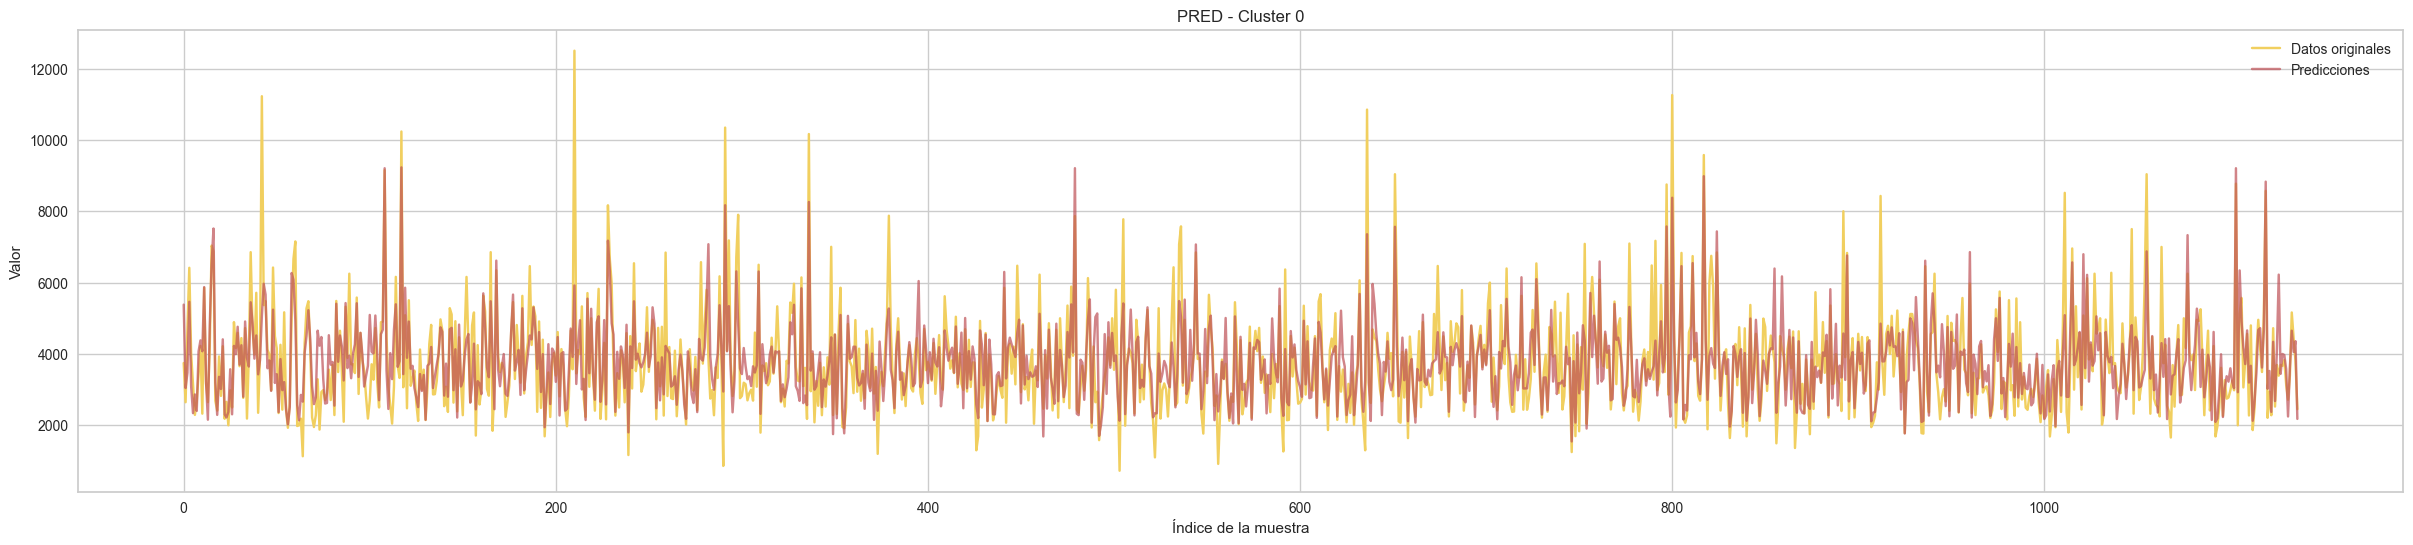

In [104]:
y_test_0.reset_index(drop=True, inplace=True)

sorted_indices = np.argsort(y_test_0)
sorted_y_test = y_test_0.iloc[sorted_indices]
sorted_predictions = predicc_0[sorted_indices]

plt.figure(figsize=(30, 6))
plt.plot(y_test_0, color=color_originales, label='Datos originales')
plt.plot(predicc_0, color=color_pred_0, alpha=a, label='Predicciones')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('PRED - Cluster 0')
plt.legend()
plt.gca().set_facecolor('none')
plt.show()

#### Cluster 1

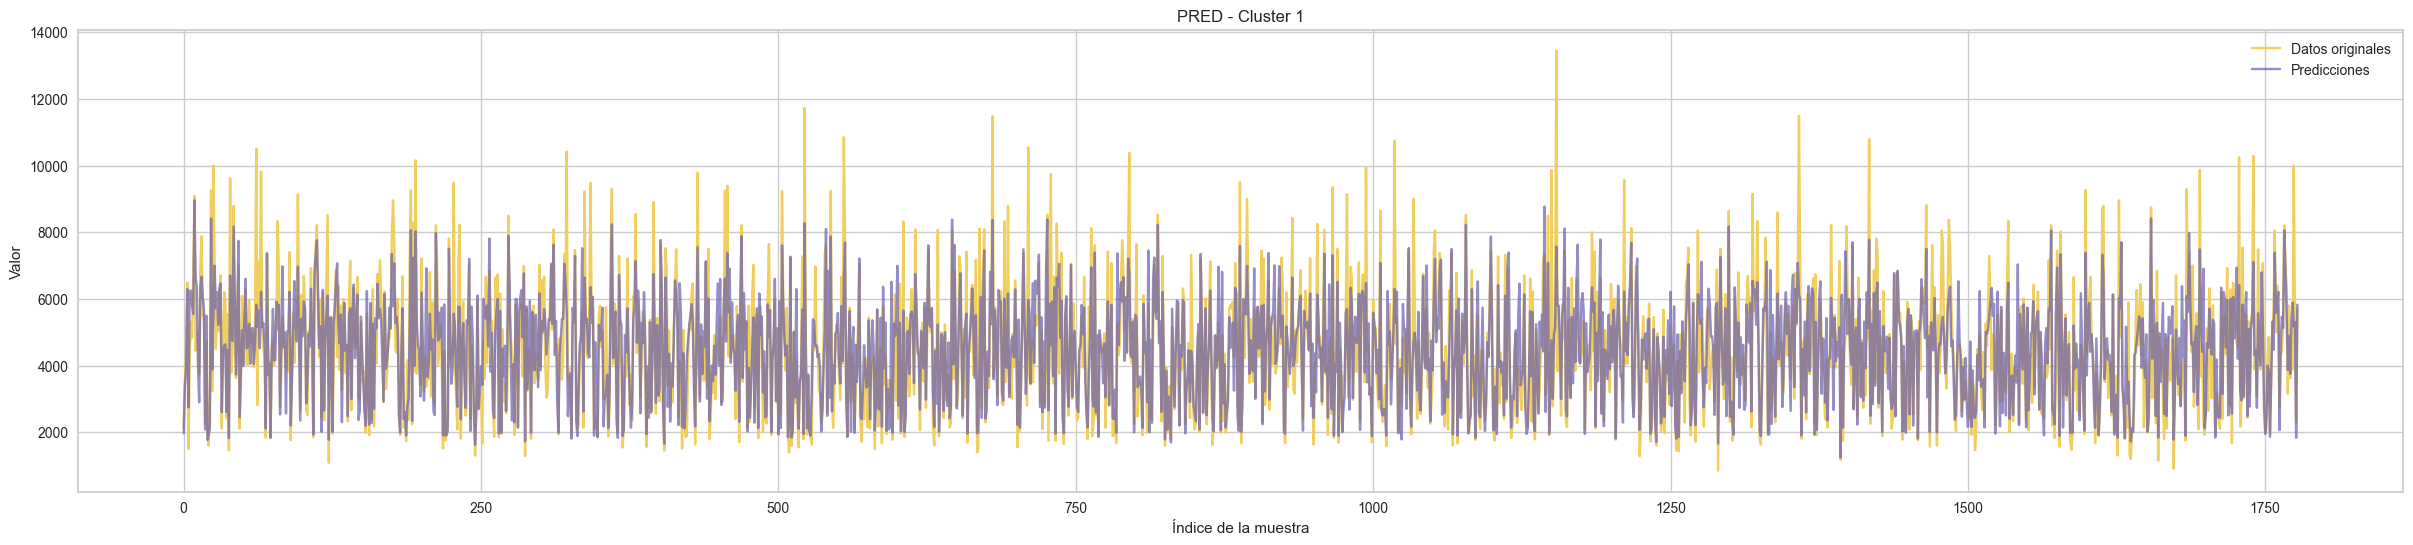

In [105]:
y_test_1.reset_index(drop=True, inplace=True)

sorted_indices = np.argsort(y_test_1)
sorted_y_test = y_test_1.iloc[sorted_indices]
sorted_predictions = predicc_1[sorted_indices]

plt.figure(figsize=(30, 6))
plt.plot(y_test_1,color=color_originales, label='Datos originales')
plt.plot(predicc_1, color=color_pred_1, alpha=a, label='Predicciones')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('PRED - Cluster 1')
plt.legend()
plt.gca().set_facecolor('none')
plt.show()

#### Cluster 2

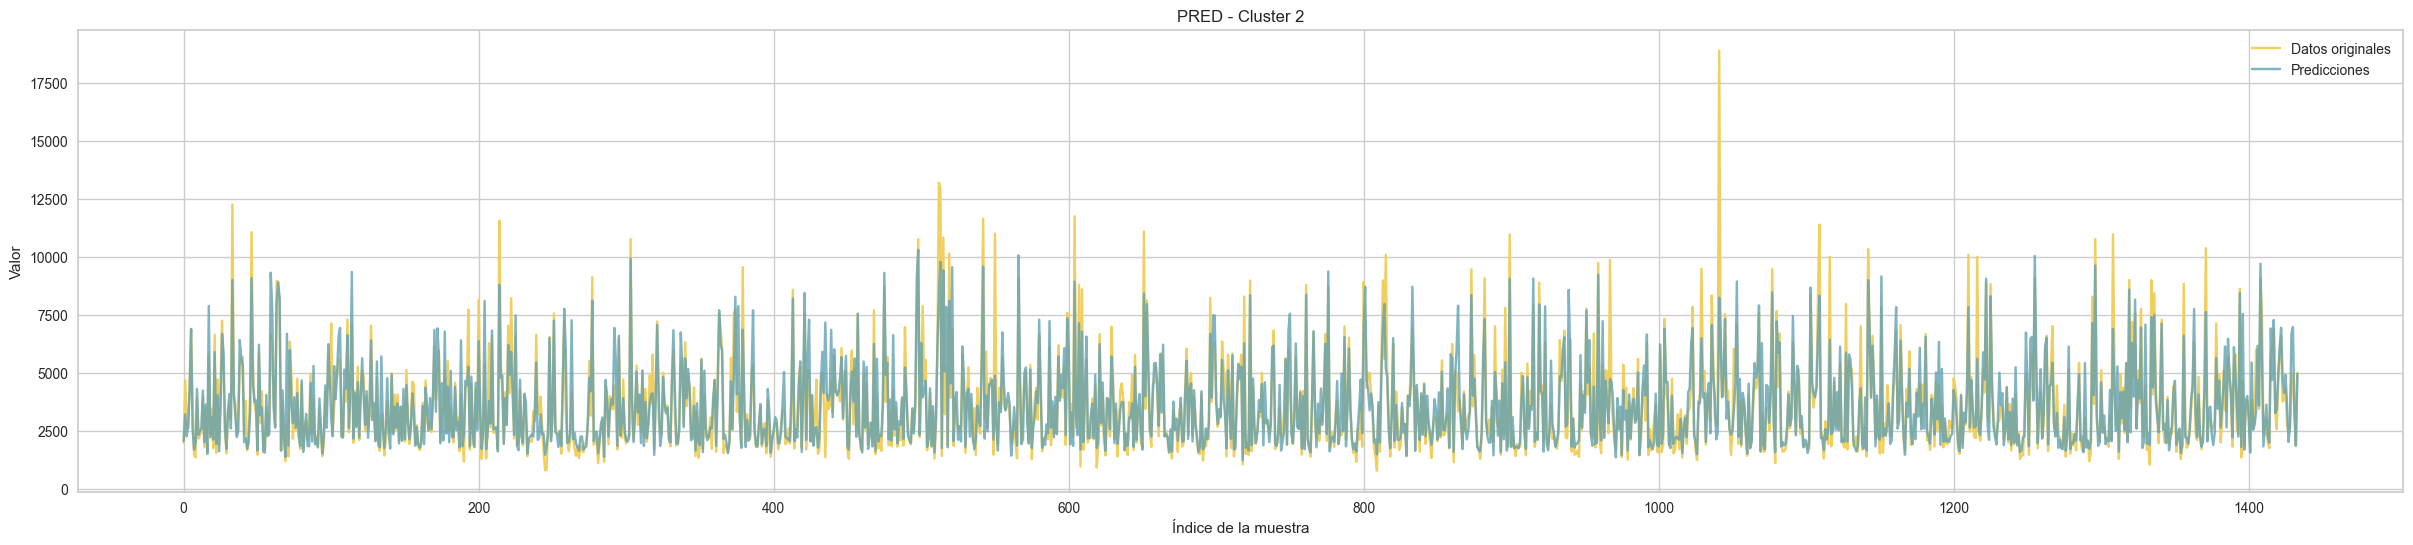

In [107]:
y_test_2.reset_index(drop=True, inplace=True)

sorted_indices = np.argsort(y_test_2)
sorted_y_test = y_test_2.iloc[sorted_indices]
sorted_predictions = predicc_2[sorted_indices]

plt.figure(figsize=(30, 6))
plt.plot(y_test_2,color=color_originales, label='Datos originales')
plt.plot(predicc_2, color=color_pred_2, alpha=0.8, label='Predicciones')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('PRED - Cluster 2')
plt.legend()
plt.gca().set_facecolor('none')
plt.show()